# PFPF_LEDH Filter Demonstration

This notebook demonstrates the **PFPF_LEDH (Particle Filtering with Particle Flow - Localized EDH)** filter, which implements Algorithm 1 from:

> Yunpeng Li and Mark J. Coates, "Particle Filtering with Invertible Particle Flow,"  
> IEEE Trans. Signal Process., vol. 65, no. 15, pp. 4102-4116, Aug. 2017.

## Key Features of PFPF_LEDH:

- **Local Linearization**: Each particle has its own flow parameters A^i(λ) and b^i(λ)
- **Invertible Mapping**: Uses Jacobian determinants θ^i for accurate weight updates
- **Better Accuracy**: Outperforms EDH when measurement models vary significantly across state space
- **Higher Computational Cost**: O(N_p × S³) vs O(S³) for EDH

## 1. Setup and Imports

In [1]:
# --- standard libs ---
import sys
from pathlib import Path

# --- project root (for Jupyter) ---
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import acoustic model functions
from acoustic_function import (
    initialize_acoustic_model,
    simulate_trajectory,
    compute_observation_jacobian,
    observation_model,
    state_transition
)

from prove_function import (
    plot_true_vs_estimated_trajectories, 
    compute_omat_per_timestep, 
    find_acoustic_position, 
    compute_position_error_noraml_acousitc
)

# Import PFPF_LEDH and PFPF_EDH classes for comparison
from pfpf_ledh import PFPF_LEDH
from pfpf_edh import PFPF_EDH
from ekf_ukf_pf.ekf import ExtendedKalmanFilter

tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

We use a multi-target acoustic tracking scenario with:
- 4 targets moving in a 40m × 40m area
- 25 sensors in a 5×5 grid
- Highly nonlinear measurement model (amplitude inversely proportional to distance)

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

# Get filter functions for EKF
state_transition_fn = state_transition # x_t = A * x_{t-1}
observation_fn = observation_model #  z_t = h(x_t) 
A = model_params["Phi"]
state_transition_jacobian_fn = lambda x: A # A
observation_jacobian_fn = compute_observation_jacobian

state_transition_fn = lambda x: state_transition(
    x, model_params, use_real_noise=False, no_noise=True
)

observation_fn = lambda x: observation_model(
    x, model_params, no_noise=True
)

state_transition_jacobian_fn = lambda x, u=None: model_params["Phi"]

observation_jacobian_fn = lambda x: compute_observation_jacobian(
    x, model_params
)

# Create EKF instance
ekf = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=model_params['Q'],
    R=model_params['R'],
    x0=model_params['x0_initial_target_states'],
    Sigma0=model_params['P0'] ,
    state_transition_jacobian_fn=state_transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn,
    use_joseph_form=True
)

## 3. Generate Ground Truth Data

In [3]:
# Generate ground truth trajectory and measurements
T = 30  # Number of time steps
print(f"Generating {T} time steps of data...")
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)
print(f"Ground truth shape: {ground_truth.shape}")
print(f"Measurements shape: {measurements.shape}")

Generating 30 time steps of data...
Ground truth shape: (16, 31)
Measurements shape: (25, 30)


## 4. Run PFPF_LEDH Filter

Create and run the PFPF_LEDH filter with local linearization.

In [4]:
# Create PFPF_LEDH filter instance
pfpf_ledh_filter = PFPF_LEDH(
    observation_jacobian=compute_observation_jacobian,
    observation_model=observation_model,
    state_transition=state_transition,
    n_particle=500,
    n_lambda=29,
    lambda_ratio=1.2,
    use_ekf=False,
    # ekf_filter=ekf,
    resample_threshold=1,
    verbose=True
)

# Run the filter
estimates_ledh, particles_ledh, covariances_ledh, Neff_ledh = pfpf_ledh_filter.run(
    measurements, model_params
)


Running PFPF_LEDH Filter (Local Linearization):
  Particles: 500
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Local (LEDH)
  EKF Covariance: Disabled
  Resample threshold: 1
  Time steps: 30
  Initialized uniform particle weights
  Initialized PFPF state variables
  Initialized PFPF_LEDH (local linearization)

Processing time steps...
    Resampled (N_eff=106.3)
    Resampled (N_eff=158.2)
    Resampled (N_eff=55.5)
    Resampled (N_eff=84.2)
    Resampled (N_eff=58.9)
    Resampled (N_eff=101.1)
    Resampled (N_eff=67.7)
    Resampled (N_eff=98.4)
    Resampled (N_eff=28.9)
  Step 10/30
    Resampled (N_eff=54.1)
    Resampled (N_eff=56.1)
    Resampled (N_eff=45.1)
    Resampled (N_eff=18.3)
    Resampled (N_eff=32.2)
    Resampled (N_eff=29.5)
    Resampled (N_eff=13.2)
    Resampled (N_eff=30.0)
    Resampled (N_eff=22.8)
    Resampled (N_eff=31.4)
  Step 20/30
    Resampled (N_eff=29.7)
    Resampled (N_eff=58.0)
    Resampled (N_eff=37.5)
    Resampled (N_eff=23.7)
 

## 5. Run PFPF_EDH Filter for Comparison

Run the EDH (global linearization) version for comparison.

In [5]:
# Reset random seeds for fair comparison
tf.random.set_seed(42)
np.random.seed(42)

# Create PFPF_EDH filter instance
pfpf_edh_filter = PFPF_EDH(
    observation_jacobian=compute_observation_jacobian,
    observation_model=observation_model,
    state_transition=state_transition,
    n_particle=500,
    n_lambda=29,
    lambda_ratio=1.2,
    use_ekf=False,
    # ekf_filter=ekf,
    resample_threshold=1,
    verbose=True
)

# Run the filter
estimates_edh, particles_edh, covariances_edh, Neff_edh = pfpf_edh_filter.run(
    measurements, model_params
)


Running PFPF Filter:
  Particles: 500
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Global (EDH)
  EKF Covariance: Disabled
  Resample threshold: 1
  Time steps: 30
  Initialized uniform particle weights
  Initialized PFPF state variables

Processing time steps...
t 0
    Resampled (N_eff=25.7)
t 1
    Resampled (N_eff=135.8)
t 2
    Resampled (N_eff=7.0)
t 3
    Resampled (N_eff=24.2)
t 4
    Resampled (N_eff=40.0)
t 5
    Resampled (N_eff=26.1)
t 6
    Resampled (N_eff=47.3)
t 7
    Resampled (N_eff=5.2)
t 8
    Resampled (N_eff=32.7)
  Step 10/30
t 9
    Resampled (N_eff=45.4)
t 10
    Resampled (N_eff=21.4)
t 11
    Resampled (N_eff=57.7)
t 12
    Resampled (N_eff=62.0)
t 13
    Resampled (N_eff=41.2)
t 14
    Resampled (N_eff=17.6)
t 15
    Resampled (N_eff=4.7)
t 16
    Resampled (N_eff=19.8)
t 17
    Resampled (N_eff=33.9)
t 18
    Resampled (N_eff=8.2)
  Step 20/30
t 19
    Resampled (N_eff=3.7)
t 20
    Resampled (N_eff=9.6)
t 21
    Resampled (N_eff=54.8)
t 22
    

## 6. Evaluate Performance

Compare PFPF_LEDH and PFPF_EDH performance.

In [6]:
# Compute errors for both filters
errors_ledh, mean_error_ledh = compute_position_error_noraml_acousitc(
    estimates_ledh, ground_truth[:, 1:], model_params['n_targets']
)
errors_edh, mean_error_edh = compute_position_error_noraml_acousitc(
    estimates_edh, ground_truth[:, 1:], model_params['n_targets']
)

rmse_ledh = tf.sqrt(tf.reduce_mean((estimates_ledh - ground_truth[:, 1:])**2))
rmse_edh = tf.sqrt(tf.reduce_mean((estimates_edh - ground_truth[:, 1:])**2))

print("="*70)
print("PERFORMANCE COMPARISON: PFPF_LEDH vs PFPF_EDH")
print("="*70)
print("\nPFPF_LEDH (Local Linearization):")
print(f"  Overall RMSE: {rmse_ledh.numpy():.4f} m")
print(f"  Mean position error (final): {mean_error_ledh[-1].numpy():.4f} m")
print(f"  Mean position error (average): {tf.reduce_mean(mean_error_ledh).numpy():.4f} m")
print(f"  Average Effective Sample Size: {tf.reduce_mean(Neff_ledh).numpy():.2f}")
print("\n  Per-target average errors:")
for i in range(model_params['n_targets']):
    print(f"    Target {i+1}: {tf.reduce_mean(errors_ledh[i]).numpy():.4f} m")

print("\nPFPF_EDH (Global Linearization):")
print(f"  Overall RMSE: {rmse_edh.numpy():.4f} m")
print(f"  Mean position error (final): {mean_error_edh[-1].numpy():.4f} m")
print(f"  Mean position error (average): {tf.reduce_mean(mean_error_edh).numpy():.4f} m")
print(f"  Average Effective Sample Size: {tf.reduce_mean(Neff_edh).numpy():.2f}")
print("\n  Per-target average errors:")
for i in range(model_params['n_targets']):
    print(f"    Target {i+1}: {tf.reduce_mean(errors_edh[i]).numpy():.4f} m")

print("\n" + "="*70)
improvement = (rmse_edh.numpy() - rmse_ledh.numpy()) / rmse_edh.numpy() * 100
print(f"LEDH Improvement over EDH: {improvement:.2f}%")
print("="*70)

PERFORMANCE COMPARISON: PFPF_LEDH vs PFPF_EDH

PFPF_LEDH (Local Linearization):
  Overall RMSE: 0.4393 m
  Mean position error (final): 0.6268 m
  Mean position error (average): 0.5635 m
  Average Effective Sample Size: 45.97

  Per-target average errors:
    Target 1: 0.5843 m
    Target 2: 0.4446 m
    Target 3: 0.6493 m
    Target 4: 0.5760 m

PFPF_EDH (Global Linearization):
  Overall RMSE: 0.4723 m
  Mean position error (final): 0.6136 m
  Mean position error (average): 0.5569 m
  Average Effective Sample Size: 27.85

  Per-target average errors:
    Target 1: 0.6334 m
    Target 2: 0.4608 m
    Target 3: 0.5849 m
    Target 4: 0.5484 m

LEDH Improvement over EDH: 6.98%


In [7]:
estimates_ledh_position, ground_truth_position = find_acoustic_position(estimates_ledh, ground_truth[:, 1:])
estimates_edh_position, ground_truth_position = find_acoustic_position(estimates_edh, ground_truth[:, 1:])

Average OMAT LEDH error: 0.5635
Final LEDH EHD error: 0.6268


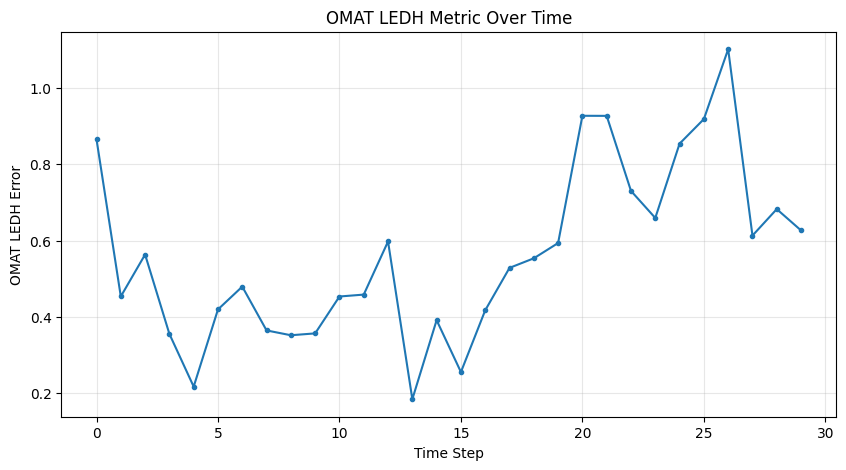

In [8]:
# Test with sample data
n_target = 2  # Each target has 2 state dimensions (e.g., x, y)
num_targets = 4  # Number of targets
omat_ledh_errors = compute_omat_per_timestep(ground_truth_position, estimates_ledh_position, num_targets, n_target, p = 1)
omat_edh_errors = compute_omat_per_timestep(ground_truth_position, estimates_edh_position, num_targets, n_target, p = 1)

print(f"Average OMAT LEDH error: {tf.reduce_mean(omat_ledh_errors):.4f}")
print(f"Final LEDH EHD error: {omat_ledh_errors[-1]:.4f}")
# Plot OMAT over time
plt.figure(figsize=(10, 5))
plt.plot(omat_ledh_errors.numpy(), marker='o', markersize=3)
plt.xlabel('Time Step')
plt.ylabel('OMAT LEDH Error')
plt.title('OMAT LEDH Metric Over Time')
plt.grid(True, alpha=0.3)
plt.show()

Average OMAT EDH error: 0.5569
Final EDH EHD error: 0.6136


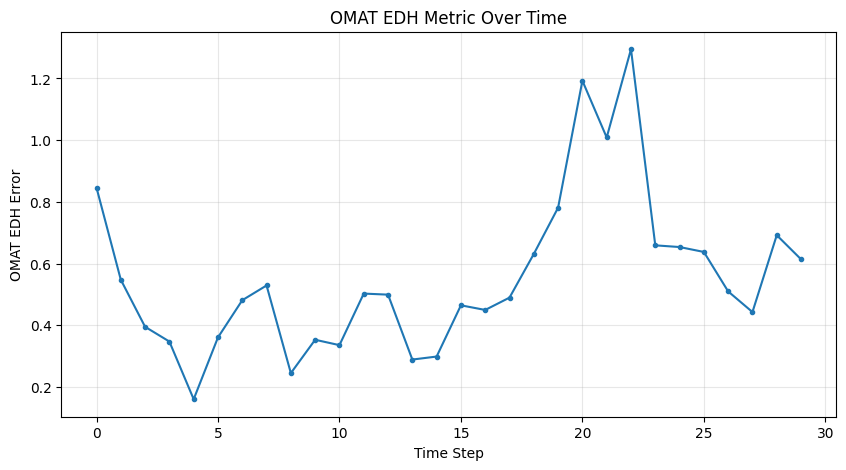

In [9]:

print(f"Average OMAT EDH error: {tf.reduce_mean(omat_edh_errors):.4f}")
print(f"Final EDH EHD error: {omat_edh_errors[-1]:.4f}")
# Plot OMAT over time
plt.figure(figsize=(10, 5))
plt.plot(omat_edh_errors.numpy(), marker='o', markersize=3)
plt.xlabel('Time Step')
plt.ylabel('OMAT EDH Error')
plt.title('OMAT EDH Metric Over Time')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Visualize Results

Plot trajectories and error evolution.

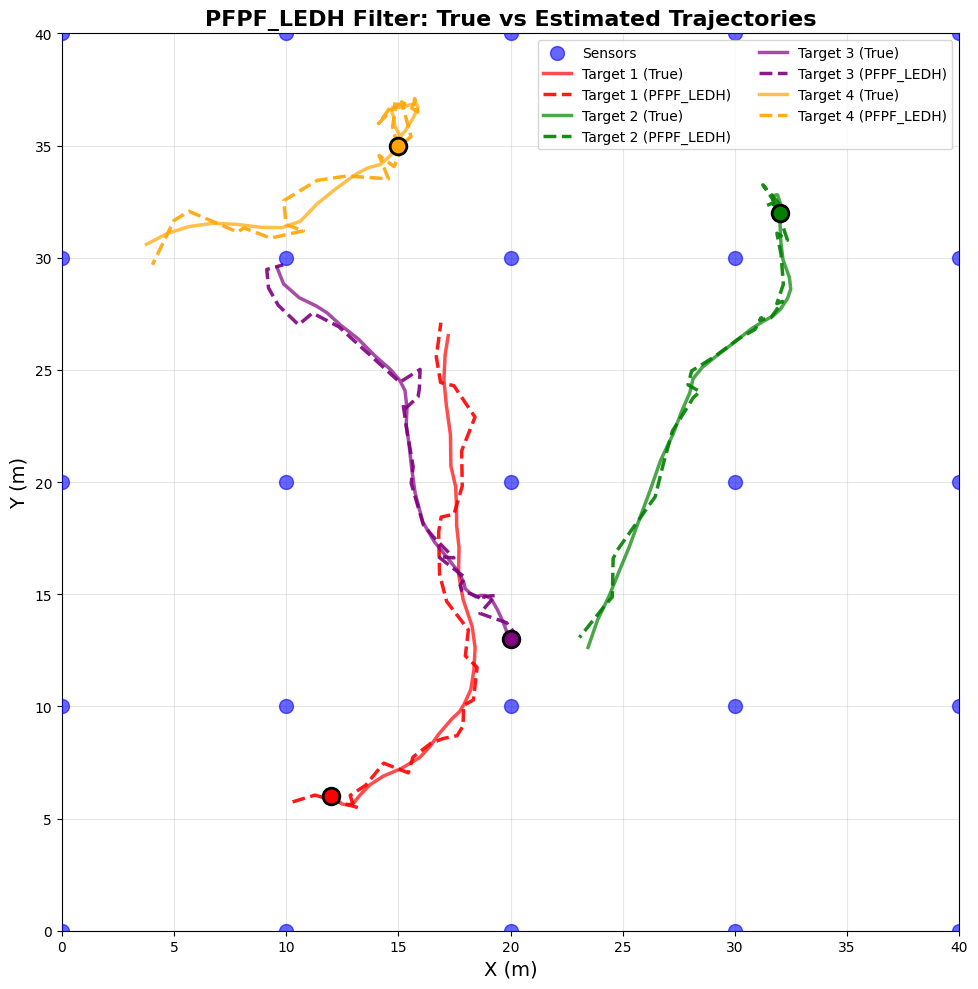

In [10]:
# Plot PFPF_LEDH trajectories
plot_true_vs_estimated_trajectories(
    model_params,
    ground_truth,
    estimates_ledh,
    title="PFPF_LEDH Filter: True vs Estimated Trajectories",
    estimate_label="PFPF_LEDH",
    figsize=(12, 10),
    colors=None
)

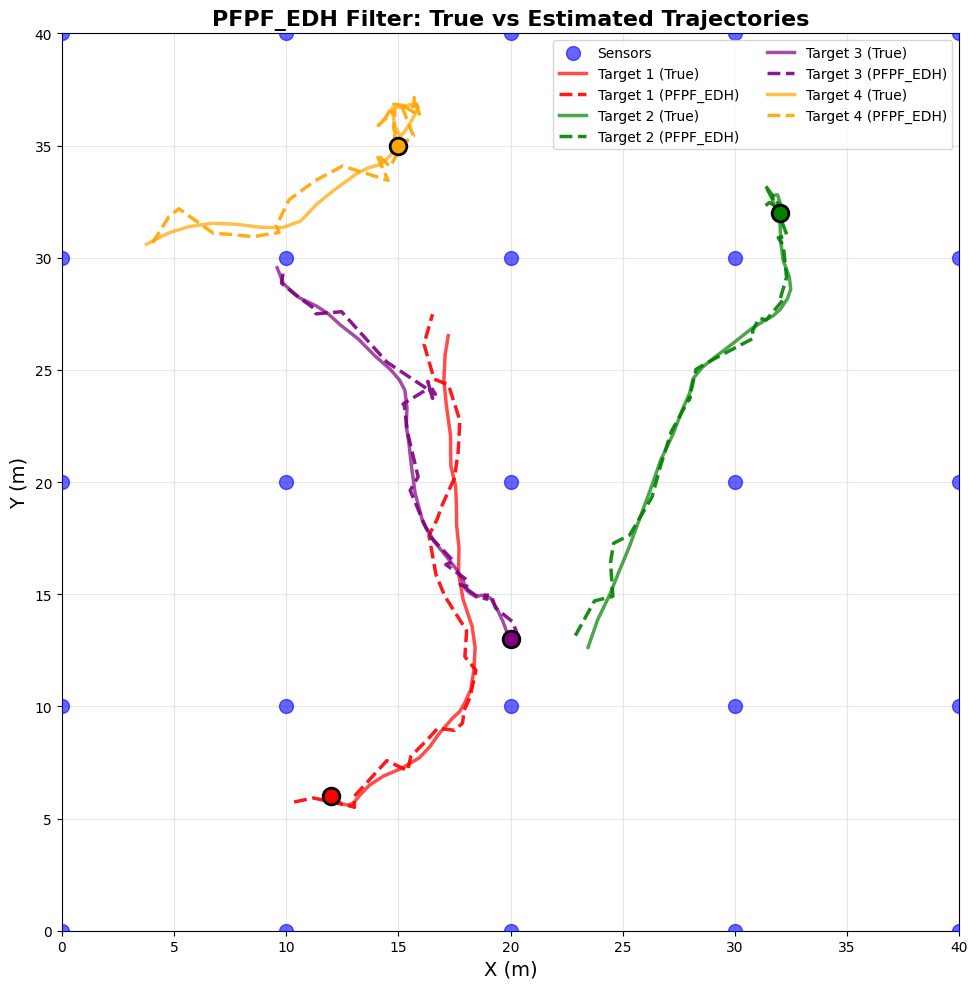

In [11]:
# Plot PFPF_EDH trajectories for comparison
plot_true_vs_estimated_trajectories(
    model_params,
    ground_truth,
    estimates_edh,
    title="PFPF_EDH Filter: True vs Estimated Trajectories",
    estimate_label="PFPF_EDH",
    figsize=(12, 10),
    colors=None
)

## 8. Plot Error Evolution Over Time

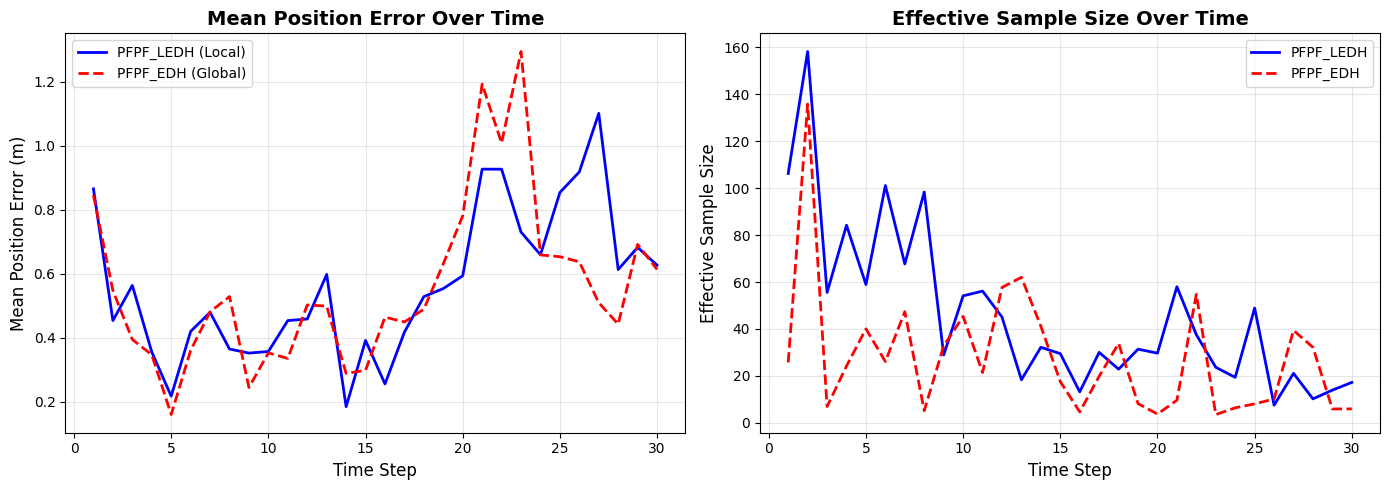

In [12]:
# Plot mean position error over time
plt.figure(figsize=(14, 5))

# Subplot 1: Mean Position Error
plt.subplot(1, 2, 1)
time_steps = np.arange(1, T+1)
plt.plot(time_steps, mean_error_ledh.numpy(), 'b-', linewidth=2, label='PFPF_LEDH (Local)')
plt.plot(time_steps, mean_error_edh.numpy(), 'r--', linewidth=2, label='PFPF_EDH (Global)')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Mean Position Error (m)', fontsize=12)
plt.title('Mean Position Error Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Subplot 2: Effective Sample Size
plt.subplot(1, 2, 2)
plt.plot(time_steps, Neff_ledh.numpy(), 'b-', linewidth=2, label='PFPF_LEDH')
plt.plot(time_steps, Neff_edh.numpy(), 'r--', linewidth=2, label='PFPF_EDH')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Effective Sample Size', fontsize=12)
plt.title('Effective Sample Size Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Per-Target Error Comparison

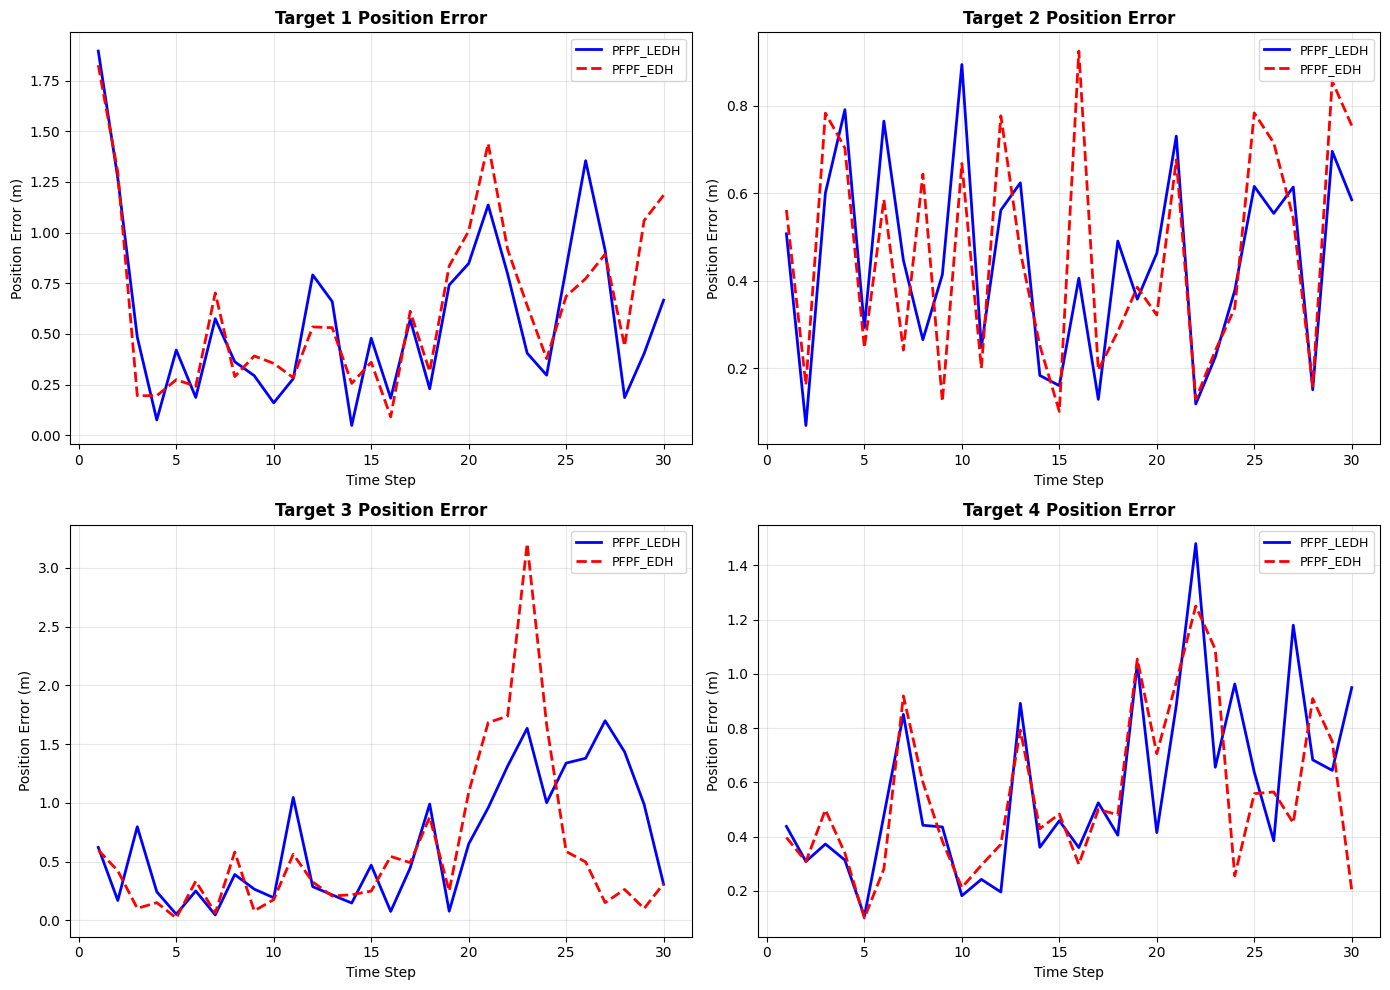

In [13]:
# Plot per-target errors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i in range(model_params['n_targets']):
    axes[i].plot(time_steps, errors_ledh[i].numpy(), 'b-', linewidth=2, label='PFPF_LEDH')
    axes[i].plot(time_steps, errors_edh[i].numpy(), 'r--', linewidth=2, label='PFPF_EDH')
    axes[i].set_xlabel('Time Step', fontsize=10)
    axes[i].set_ylabel('Position Error (m)', fontsize=10)
    axes[i].set_title(f'Target {i+1} Position Error', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Summary Statistics

In [14]:
# Create summary table
import pandas as pd

summary_data = {
    'Metric': [
        'Overall RMSE (m)',
        'Mean Error (m)',
        'Final Error (m)',
        'Avg ESS',
        'Min ESS',
        'Target 1 Avg Error (m)',
        'Target 2 Avg Error (m)',
        'Target 3 Avg Error (m)',
        'Target 4 Avg Error (m)'
    ],
    'PFPF_LEDH': [
        f"{rmse_ledh.numpy():.4f}",
        f"{tf.reduce_mean(mean_error_ledh).numpy():.4f}",
        f"{mean_error_ledh[-1].numpy():.4f}",
        f"{tf.reduce_mean(Neff_ledh).numpy():.2f}",
        f"{tf.reduce_min(Neff_ledh).numpy():.2f}",
        f"{tf.reduce_mean(errors_ledh[0]).numpy():.4f}",
        f"{tf.reduce_mean(errors_ledh[1]).numpy():.4f}",
        f"{tf.reduce_mean(errors_ledh[2]).numpy():.4f}",
        f"{tf.reduce_mean(errors_ledh[3]).numpy():.4f}"
    ],
    'PFPF_EDH': [
        f"{rmse_edh.numpy():.4f}",
        f"{tf.reduce_mean(mean_error_edh).numpy():.4f}",
        f"{mean_error_edh[-1].numpy():.4f}",
        f"{tf.reduce_mean(Neff_edh).numpy():.2f}",
        f"{tf.reduce_min(Neff_edh).numpy():.2f}",
        f"{tf.reduce_mean(errors_edh[0]).numpy():.4f}",
        f"{tf.reduce_mean(errors_edh[1]).numpy():.4f}",
        f"{tf.reduce_mean(errors_edh[2]).numpy():.4f}",
        f"{tf.reduce_mean(errors_edh[3]).numpy():.4f}"
    ]
}

df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(df.to_string(index=False))
print("="*70)


SUMMARY TABLE
                Metric PFPF_LEDH PFPF_EDH
      Overall RMSE (m)    0.4393   0.4723
        Mean Error (m)    0.5635   0.5569
       Final Error (m)    0.6268   0.6136
               Avg ESS     45.97    27.85
               Min ESS      7.50     3.51
Target 1 Avg Error (m)    0.5843   0.6334
Target 2 Avg Error (m)    0.4446   0.4608
Target 3 Avg Error (m)    0.6493   0.5849
Target 4 Avg Error (m)    0.5760   0.5484


## Conclusions

This demonstration shows that:

1. **PFPF_LEDH** (local linearization) typically provides **better accuracy** than PFPF_EDH (global linearization) for nonlinear measurement models
2. The improvement comes from linearizing at each particle's position rather than at the global mean
3. **Trade-off**: LEDH is computationally more expensive (O(N_p × S³) vs O(S³))
4. Both filters maintain good effective sample sizes, avoiding particle degeneracy

### When to use PFPF_LEDH:
- Measurement function varies significantly over state space
- High accuracy is more important than computational efficiency
- Multi-target tracking with nonlinear sensor models

### When to use PFPF_EDH:
- Computational efficiency is critical
- Measurement function is approximately linear
- Real-time applications with limited computational resources